In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
!pip install pretrainedmodels
!pip install torch_optimizer

In [0]:
import os
import numpy as np 
import pandas as pd 
import glob
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

from imgaug import augmenters as iaa

from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.optim as optim
import torch_optimizer as optim1

import pretrainedmodels
from pretrainedmodels import resnet50
from pretrainedmodels.models import resnext101_32x4d as ResNext50
from pretrainedmodels.models import senet154 as SeNet

from tqdm import tqdm_notebook as tqdm

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

In [0]:
train_paths = glob.glob('/content/gdrive/My Drive/Kaggle/224-224-cervical-cancer-screening/kaggle/train/train/*/*.jpg')
test_paths = glob.glob('/content/gdrive/My Drive/Kaggle/224-224-cervical-cancer-screening/kaggle/test_stg2/*.jpg') 
# validation_paths = glob.glob('/content/gdrive/My Drive/Kaggle/224-224-cervical-cancer-screening/kaggle/validation/validation/*/*.jpg')
train_paths, validation_paths = train_test_split(train_paths, test_size=0.1, random_state=2018)
print(len(test_paths))

In [0]:
sometimes = lambda aug: iaa.Sometimes(0.5, aug)
seq = iaa.Sequential([
                        sometimes(iaa.ElasticTransformation(alpha=(0, 10), sigma=10)),
                        sometimes(iaa.Affine(translate_px=(-30, 30), rotate=(-120, 120), cval=0)),
                        sometimes(iaa.Crop(percent=(0, 0.1))),
                        sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05)))],
            # do all of the above augmentations in random order
            random_order=True)

class MCCSDataset(Dataset):
        def __init__(self, paths, train=True, transform=None, size=256):
            super(MCCSDataset, self).__init__()
            self.paths = paths
            self.train = train
            self.size = size
            self.transform = transform

        def __getitem__(self, idx):
            path = self.paths[idx]
            label = path.split('/')[-2].split('_')[-1]
                
            img = plt.imread(path)
                        
            if self.train:
                img = seq.augment_image(img)

            if self.transform:
                img = transforms.ToPILImage()(img)
                img = self.transform(img)
            y_one_encode = torch.zeros(3)
            y_one_encode[int(label) -1] = 1.

            return img, y_one_encode

        def __len__(self):
            return len(self.paths)

In [0]:
class LeNet(nn.Module):

#image size : 224X224X3
    #dim_after_conv = input_size -(filter_zise - 1)
    #dim_after_max_pool = input_size /2 

    # size of input image :  224x224X3
    # after first conv2d : 224 - (5 -1) = 220, #224 - (5 -1) = 220
    # img size : 220x220x6

    # after max_pool :220/2 = 110 , #220/2= 110
    # img size = 110x110x6

    #after 2nd conv2d : 110 - (5-1) = 106 , #110- (5-1) = 106
    #img size : 106x106x16

    # after max_pool :106/2= 53, #106/2= 53
    # img size = 53x53x16

    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1   = nn.Linear(53*53*16, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 3)
        
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x.float())), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        y = F.softmax(x, dim=1).double()
        return y

In [0]:
BS = 64
train_transforms = transforms.Compose([ 
                                        transforms.RandomHorizontalFlip(),
                                        transforms.RandomRotation((-120, 120)),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
test_transforms = transforms.Compose([
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

trainset = MCCSDataset(train_paths, transform=train_transforms, train=True)
valset = MCCSDataset(validation_paths, transform=test_transforms, train=False)
train_loader = DataLoader(trainset, batch_size=BS, shuffle=True, num_workers=4)
val_loader = DataLoader(valset, batch_size=BS, shuffle=False, num_workers=4)

In [0]:
def norm(img):
    img -=img.min()
    img/=img.max()
    return img

def optimizers(model, option, lr=0.01, wd=1e-5): 
    optimizer = {
                    'sgd': optim.SGD(model.parameters(), lr=lr),
                    'adam': optim.Adam(model.parameters(), lr=lr, weight_decay=wd),
                    'radam': optim1.RAdam(model.parameters(), weight_decay=wd)}
    
    return optimizer[option]

def train_loop(train_dataloader, validation_dataloader, epochs, model, loss_function, optimizer):
    model_estimation_parameters = {
                                    'train_loss': [],
                                    'train_accuracy': [],
                                   'validition_loss': [],
                                   'validition_accuracy': []
    }
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=epochs//4, gamma=0.1)
    loss = loss_function()
    loss.to(device)
    from tqdm import tqdm_notebook as tqdm
    for epoch in range(epochs):
        batch_estimation = np.zeros(2)
        for batch in tqdm(train_dataloader):
            xt , yt = batch[0].to(device), batch[1].to(device)
            optimizer.zero_grad()
            output = model(xt)
            train_loss = loss(output.double(), yt.double())
            train_loss.backward()
            optimizer.step()
            batch_estimation[0] += evaluate(output, yt)
            batch_estimation[1] += train_loss.item()

        batch_estimation = batch_estimation / len(train_dataloader)
        print('Train performence: [%d, %5d] loss: %f, accuracy= %f' % (epoch, len(train_dataloader), batch_estimation[1], batch_estimation[0]*100))
        model_estimation_parameters['train_loss'].append(batch_estimation[1])
        model_estimation_parameters['train_accuracy'].append(batch_estimation[0])

        with torch.no_grad():
            batch_estimation = np.zeros(2)
            for batch in validation_dataloader:
                xv , yv = batch[0].to(device), batch[1].to(device)
                optimizer.zero_grad()
                output = model(xv)
                val_loss = loss(output.double(), yv.double())
                batch_estimation[0] += evaluate(output, yv)
                batch_estimation[1] += train_loss.item()

            batch_estimation = batch_estimation / len(validation_dataloader)
            print('validation performence: [%d, %5d] loss: %f, accuracy= %f\n' % (epoch, len(validation_dataloader), batch_estimation[1], batch_estimation[0]*100))
            model_estimation_parameters['validition_loss'].append(batch_estimation[1])
            model_estimation_parameters['validition_accuracy'].append(batch_estimation[0])

        scheduler.step()
    return model_estimation_parameters
            
def visualization(train_accuracy_list, train_loss_list):
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.plot(np.array(train_accuracy_list)*100)
    plt.title('accuracy', fontsize=20)
    plt.show()

    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 2)
    plt.plot(np.array(train_loss_list))
    plt.title('loss', fontsize=20)
    plt.show()

def evaluate (y_pred, targets):
    actual  = [torch.argmax(x) for x in targets] 
    prediction  = [torch.argmax(x) for x in y_pred]  
    corrects = 0.0
    for t, y in zip(actual, prediction):
        if t == y:
            corrects += 1.0
    return corrects/ len(actual)

In [0]:
lenet = LeNet()

lenet.to(device)
sgd = optimizers(lenet, 'sgd')
adam = optimizers(lenet, 'adam', lr=1e-3)
radam = optimizers(lenet, 'radam')

epochs = 16
dic = train_loop(train_loader, val_loader, epochs, lenet, nn.BCELoss, adam)
train_accuracy_list, train_loss_list =dic['train_accuracy'], dic['train_loss']
visualization(train_accuracy_list, train_loss_list)

In [0]:
def pretraineddmodels_trainig_loop(train_dataloader, validation_dataloader, epochs, model, loss_function, optimizer, adjust_layers):
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=epochs//4, gamma=0.1)
    model_estimation_parameters = {
                                        'train_loss': [],
                                        'train_accuracy': [],
                                    'validition_loss': [],
                                    'validition_accuracy': []
        }
    loss = loss_function()
    loss.to(device)
    for epoch in tqdm(range(epochs)):
        batch_estimation = np.zeros(2)
        model.train()
        for batch in train_dataloader:
            xt , yt = batch[0].to(device), batch[1].to(device)
            optimizer.zero_grad()
            x = model.features(xt)
            x = torch.functional.F.avg_pool2d(x, 7)
            x = x.view(x.shape[0], -1)
            train_output = adjust_layers(x)
            train_loss = loss(train_output, yt)
            train_loss.backward()
            optimizer.step()
            batch_estimation[0] += evaluate(train_output, yt)
            batch_estimation[1] += train_loss.item()

        batch_estimation = batch_estimation / len(train_dataloader)
        print('Train performence: [%d, %5d] loss: %f, accuracy= %f' % (epoch, len(train_dataloader), batch_estimation[1], batch_estimation[0]*100))
        model_estimation_parameters['train_loss'].append(batch_estimation[1])
        model_estimation_parameters['train_accuracy'].append(batch_estimation[0])

        model.eval()
        with torch.no_grad():
            batch_estimation = np.zeros(2)
            for batch in validation_dataloader:
                xv , yv = batch[0].to(device), batch[1].to(device)
                x = model.features(xv)
                x = torch.functional.F.avg_pool2d(x, 7)
                x = x.view(x.shape[0], -1)
                eval_output = adjust_layers(x)
                eval_loss = loss(eval_output, yv)
                batch_estimation[0] += evaluate(eval_output, yv)
                batch_estimation[1] += eval_loss.item()
                
            print(batch_estimation)
            batch_estimation = batch_estimation / len(validation_dataloader)
            print(batch_estimation)

            print('validation performence: [%d, %5d] loss: %f, accuracy= %f\n' % (epoch, len(validation_dataloader), batch_estimation[1], batch_estimation[0]*100))
            model_estimation_parameters['validition_loss'].append(batch_estimation[1])
            model_estimation_parameters['validition_accuracy'].append(batch_estimation[0])
        scheduler.step()
    return model_estimation_parameters

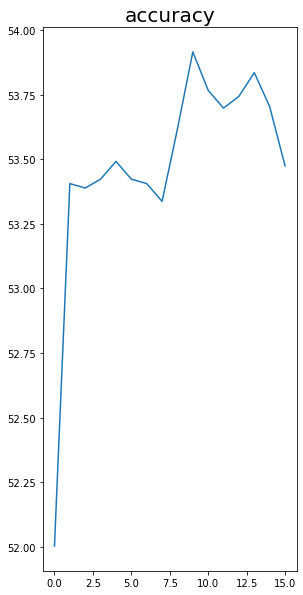
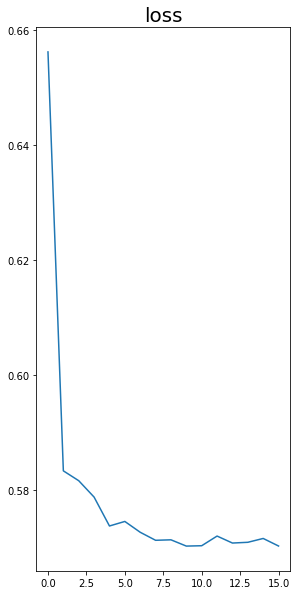

In [0]:
resnet = resnet50(num_classes=3, pretrained=None)

In [0]:
torch.cuda.empty_cache()
resnet.to(device)
epochs = 16

mylayers = torch.nn.Sequential(torch.nn.Linear(2048,64),
                             torch.nn.ReLU(),
                             torch.nn.Dropout(),
                             torch.nn.Linear(64,3)).to(device)


# sgd = optimizers(mylayers, 'sgd')
adam = optimizers(mylayers, 'adam')
# radam = optimizers(mylayers, 'radam', lr=1e-1)
# scheduler = optim.lr_scheduler.StepLR(adam, step_size=epochs//4, gamma=0.1)

dic = pretraineddmodels_trainig_loop(train_loader, val_loader,
                                                                      epochs, resnet, nn.BCEWithLogitsLoss, adam, mylayers)
train_accuracy_list, train_loss_list =dic['train_accuracy'], dic['train_loss']
visualization(train_accuracy_list, train_loss_list)

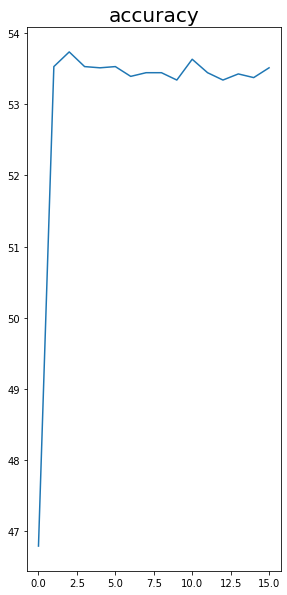
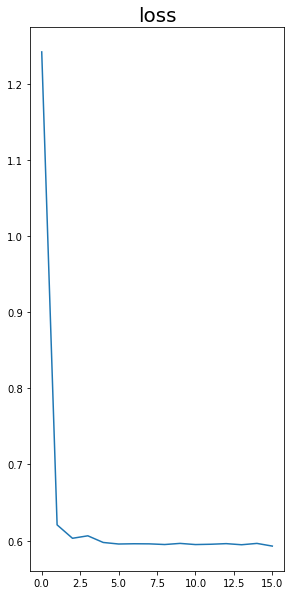

In [0]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
resnext = ResNext50()

In [0]:
torch.cuda.empty_cache()
resnext.to(device)
epochs = 16

mylayers = torch.nn.Sequential(torch.nn.Linear(2048,64),
                             torch.nn.ReLU(),
                             torch.nn.Dropout(),
                             torch.nn.Linear(64,3)).to(device)


# sgd = optimizers(mylayers, 'sgd')
adam = optimizers(mylayers, 'adam')
# radam = optimizers(mylayers, 'radam', lr=1e-1)
# scheduler = optim.lr_scheduler.StepLR(adam, step_size=epochs//4, gamma=0.1)

dic = pretraineddmodels_trainig_loop(train_loader, val_loader,
                                                                      epochs, resnext, nn.BCEWithLogitsLoss, adam, mylayers)
train_accuracy_list, train_loss_list =dic['train_accuracy'], dic['train_loss']
visualization(train_accuracy_list, train_loss_list)

In [0]:
def test_eval(model, pretrained=True):
    _input = torch.from_numpy(np.array([plt.imread(x) for x in test_paths]))
    if pretrained:
        model.eval()
    
    y_pred = model(_input[:,np.newaxis, :, :].to(device))
    y_pred = F.softmax(y_pred, dim=1).double()
    print(y_pred)

    # y_pred =[torch.argmax(x.detach().cpu()) for x in y_pred]
    # y_pred = torch.stack(y_pred)